<a href="https://colab.research.google.com/github/maciejskorski/new_pll_trng/blob/main/TRNG_Dependency_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis Module

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

from IPython.display import display
from pathlib import Path
import logging


plt.rcParams['figure.figsize'] = (10,3)
logger = logging.getLogger('TRNG Analysis')
logger.setLevel(logging.INFO)


def get_bytes_data(fpath):
  with open(fpath,'rb') as f:
    bytes_data = f.read()
  bytes_data = pd.DataFrame(list(bytes_data),columns=['byte value'])
  bytes_data.index.name = 'timestep'
  return bytes_data


def last_bit(x):
  return x % 2

def diff_last_bit(x):
  return x.diff().loc[1:] % 2


def analyze_series(bytes_data, nlags=10, alpha=0.05, postprocess_fn=last_bit):
  """ Analyze dependencies of TRNG bytes candidate.
      Args:
          bytes_data (pandas.DataFrame): series of raw bytes (das), encoded as integers uint8
          nlags (int): maximum number of lags to analyse
          alpha (float): confidence level for hypothesis testing
          postprocess_fn (function): transform applied to the series. For example, use <mod 2> to extract the last significant bit
      Return:
          figure: picture with plots
  """
  params = {
        'lags':nlags,
        'alpha':alpha,
        'postprocess_fn':postprocess_fn.__name__
  }
  mlflow.log_params(params)
  fig,axs = plt.subplots(1,2,constrained_layout=True)
  # plot histogram
  ax = axs[0]
  sns.histplot(data=bytes_data,x='byte value',ax=ax,discrete=True)
  # plot time series
  ax = axs[1]
  sns.lineplot(data=bytes_data.loc[:1000],x='timestep',y='byte value',ax=ax)
  plt.show()
  mlflow.log_figure(fig,'exploratory.png')
  bytes_data = postprocess_fn(bytes_data)
  # stationarity tests on postprocessed data
  results = kpss(bytes_data,nlags=10)
  pval = results[1]
  mlflow.log_metric(f'stationary.KPSS.lag_{nlags}',pval)
  results = adfuller(bytes_data,maxlag=10)
  pval = results[1]
  mlflow.log_metric(f'not-stationary.ADF.lag_{nlags}',pval)
  # plot autocorelation by 
  fig,ax = plt.subplots(1,1,constrained_layout=True)
  fig = plot_acf(x=bytes_data, lags = nlags, fft=True, alpha=alpha, bartlett_confint=True, zero=False, adjusted=True, ax=ax, auto_ylims=True)
  ax.set(xlabel='Lag',ylabel='Corr')
  plt.show()
  mlflow.log_figure(fig,'autocorrelation.png')
  # find p-values for autocorrelation
  _,_,_,pvals = acf(
          x=bytes_data,
          nlags=nlags,
          alpha=alpha,
          fft=True,
          bartlett_confint=True,
          adjusted=True,
          qstat=True
  )
  pvals = {'lag':np.arange(1,nlags+1),'Ljung-Box Test p-val':pvals}
  pvals = pd.DataFrame(data=pvals)
  pvals.set_index('lag',inplace=True)
  display(pvals)
  mlflow.log_metric(f'not-correlated.LjungBox.lag_{nlags}',pvals.loc[nlags])

# Data



In [ ]:
# update Python software - and restart the kernel when necessary
!pip install --upgrade statsmodels --quiet
!pip install mlflow --quiet
!pip install pyngrok --quiet

     |████████████████████████████████| 9.8 MB 5.3 MB/s 
     |████████████████████████████████| 16.9 MB 516 kB/s 
     |████████████████████████████████| 77 kB 5.9 MB/s 
     |████████████████████████████████| 79 kB 6.0 MB/s 
     |████████████████████████████████| 147 kB 53.1 MB/s 
     |████████████████████████████████| 209 kB 55.5 MB/s 
     |████████████████████████████████| 182 kB 50.7 MB/s 
     |████████████████████████████████| 78 kB 6.9 MB/s 
     |████████████████████████████████| 140 kB 49.8 MB/s 
     |████████████████████████████████| 62 kB 923 kB/s 
     |████████████████████████████████| 55 kB 2.6 MB/s 
     |████████████████████████████████| 63 kB 784 kB/s 
     |████████████████████████████████| 59 kB 5.5 MB/s 


In [ ]:
# Download the zipped files from the shared internet link:
!curl -L "https://filesender.renater.fr/download.php?token=c4a56006-e8f9-4d78-9357-d4540b99e185&files_ids=17941252" --output data_v1.zip
!unzip -q data_v1.zip -d data_v1 #FIXME: ignore, early experiment version
!curl -L "https://filesender.renater.fr/download.php?token=76f39908-16e7-4b6b-b497-5849066c7641&files_ids=17983818" --output data_v2.zip
!unzip -q data_v2.zip -d data_v2 # Cyclone V (card 2 and card 7), config A
!curl -L "https://filesender.renater.fr/download.php?token=1edb5a92-296e-4833-b71d-86e17568aeba&files_ids=17988708" --output data_v3.zip
!unzip -q data_v3.zip -d data_v3 # SmartFusion2, config A
!curl -L "https://filesender.renater.fr/download.php?token=b1339d20-8fa7-4007-8d8d-479c1476f6d2&files_ids=18160296" --output data_CV_c_and_CV_d_dff.zip
!unzip -q data_CV_c_and_CV_d_dff.zip -d data_CV_c_and_CV_d_dff 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 5838k  100 5838k    0     0   372k      0  0:00:15  0:00:15 --:--:--  459k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 13.5M  100 13.5M    0     0   438k      0  0:00:31  0:00:31 --:--:--  465k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7022k  100 7022k    0     0   426k      0  0:00:16  0:00:16 --:--:--  465k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 9861k  100 9861k    0     0   434k      0  0:00:22  0:00:22 --:--:--  455k


# Results

The conclusions are:


1.   Use the least significant bit to remove correlations. 

2.   Strong evidence for stationarity

In [ ]:
import numpy as np
import scipy
from scipy import stats
path = '/content/data_v3/220929_SFa4_DBv11-12/acq_20220929154848_cnt.bin'
x = np.fromfile(path,dtype='uint8')
corr,pval = scipy.stats.pearsonr(x[:-1],x[1:])
print(f'Counter Raw Value: Correlation={corr}, non-corr test: p-val={pval}')

y = x%2
corr,pval = scipy.stats.pearsonr(y[:-1],y[1:])
print(f'Counter Last Bit: correlation={corr}, non-corr p-val={pval}')

Counter Raw Value: Correlation=-0.050091143944789994, non-corr test: p-val=0.0
Counter Last Bit: correlation=-4.1032083376957556e-05, non-corr p-val=0.9672703750150912


## Logging

Result outcmes are tracked with `mlflow`, and interactively presented under the temporary domain set up with `ngrok`.

In [ ]:
import mlflow
from pyngrok import ngrok
from getpass import getpass

# run mlflow server
get_ipython().system_raw("mlflow ui --port 5000 &")

# Terminate open tunnels if exist
ngrok.kill()

# Setting the authtoken (optional)
# Get your authtoken from https://dashboard.ngrok.com/auth
NGROK_AUTH_TOKEN = getpass('Enter the ngrok authtoken: ')
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True,
                             auth="user:password"
                             )
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

Enter the ngrok authtoken: ··········
MLflow Tracking UI: https://6889-34-125-29-107.ngrok.io


## Experiments

INFO:TRNG Analysis:Doing experiment data_CV_c_and_CV_d_dff/CVd1


data_CV_c_and_CV_d_dff/CVd1


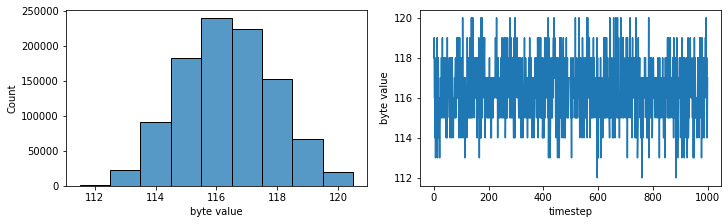

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


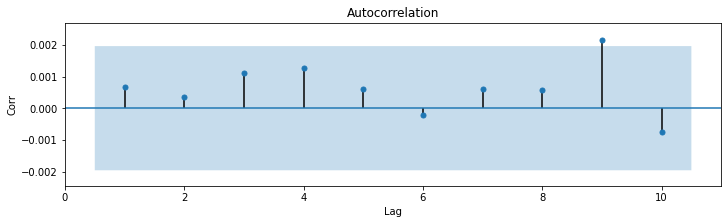

,Ljung-Box Test p-val
lag,
1,0.495261
2,0.745185
3,0.605705
4,0.483506
5,0.573019
6,0.691542
7,0.751412
8,0.802271
9,0.417248


INFO:TRNG Analysis:Doing experiment data_CV_c_and_CV_d_dff/CVd1


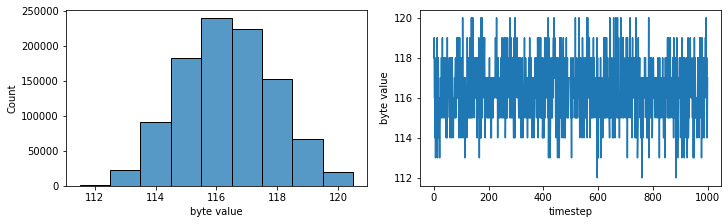

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


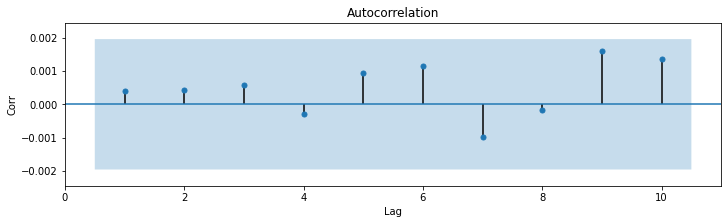

,Ljung-Box Test p-val
lag,
1,0.696921
2,0.849952
3,0.885550
4,0.948170
5,0.899370
6,0.812993
7,0.790219
8,0.862275
9,0.692869


INFO:TRNG Analysis:Doing experiment data_CV_c_and_CV_d_dff/CVd2


data_CV_c_and_CV_d_dff/CVd2


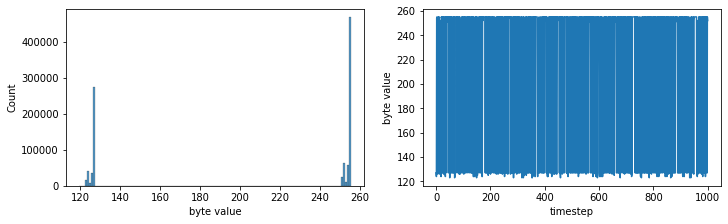

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


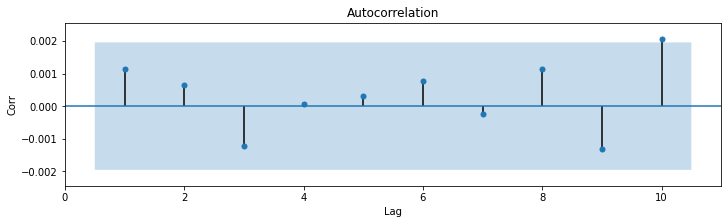

,Ljung-Box Test p-val
lag,
1,0.255003
2,0.426329
3,0.365747
4,0.528508
5,0.658739
6,0.695687
7,0.788916
8,0.735659
9,0.644718


INFO:TRNG Analysis:Doing experiment data_CV_c_and_CV_d_dff/CVd2


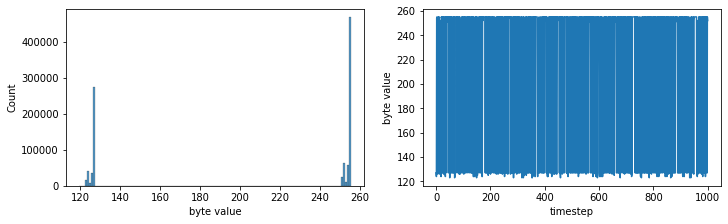

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


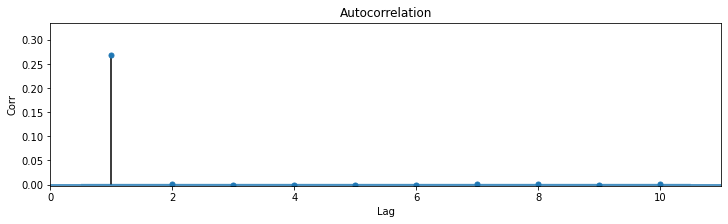

,Ljung-Box Test p-val
lag,
1,0.0
2,0.0
3,0.0
4,0.0
5,0.0
6,0.0
7,0.0
8,0.0
9,0.0


INFO:TRNG Analysis:Doing experiment data_CV_c_and_CV_d_dff/CVc1


data_CV_c_and_CV_d_dff/CVc1


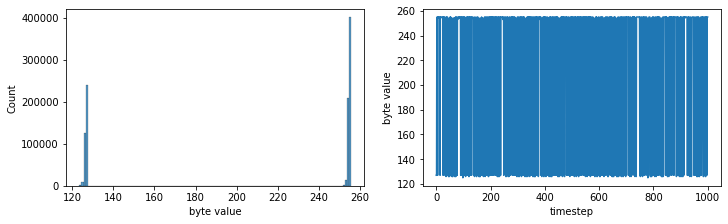

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


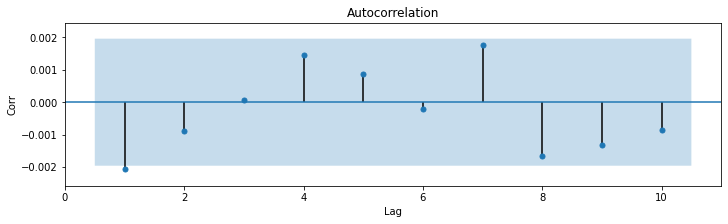

,Ljung-Box Test p-val
lag,
1,0.039049
2,0.080161
3,0.167893
4,0.124885
5,0.158497
6,0.237801
7,0.131842
8,0.085328
9,0.075748


INFO:TRNG Analysis:Doing experiment data_CV_c_and_CV_d_dff/CVc1


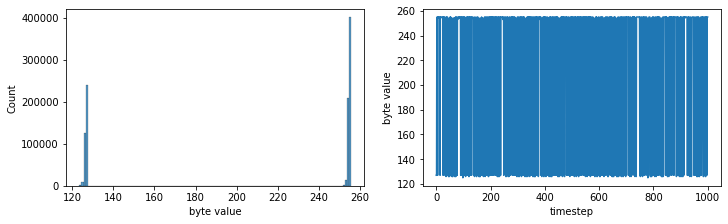

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


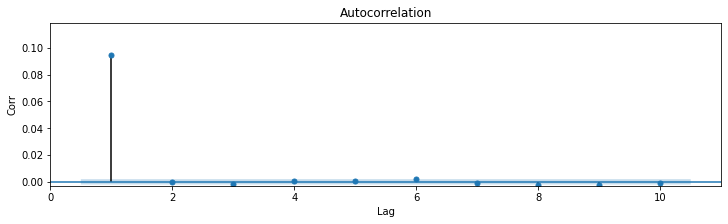

,Ljung-Box Test p-val
lag,
1,0.0
2,0.0
3,0.0
4,0.0
5,0.0
6,0.0
7,0.0
8,0.0
9,0.0


INFO:TRNG Analysis:Doing experiment data_CV_c_and_CV_d_dff/CVc2


data_CV_c_and_CV_d_dff/CVc2


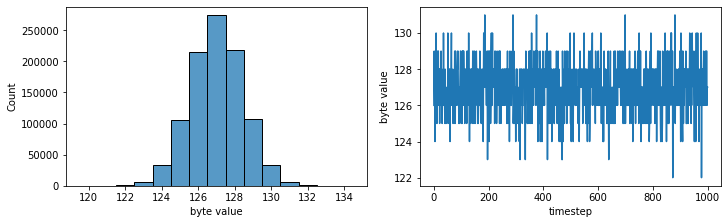

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


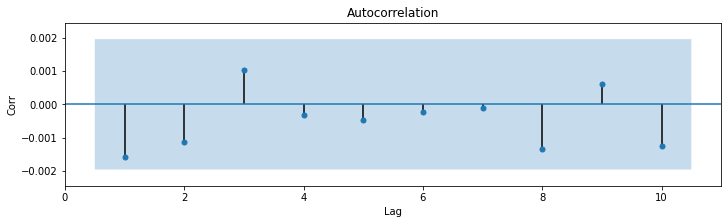

,Ljung-Box Test p-val
lag,
1,0.110241
2,0.149164
3,0.181072
4,0.289991
5,0.392676
6,0.512448
7,0.628409
8,0.526106
9,0.587176


INFO:TRNG Analysis:Doing experiment data_CV_c_and_CV_d_dff/CVc2


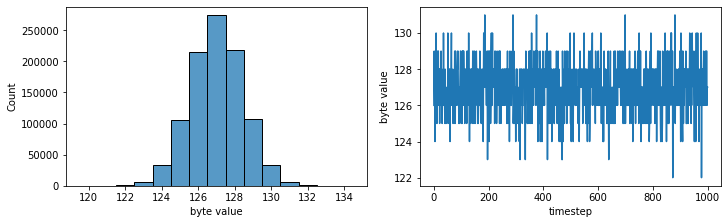

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


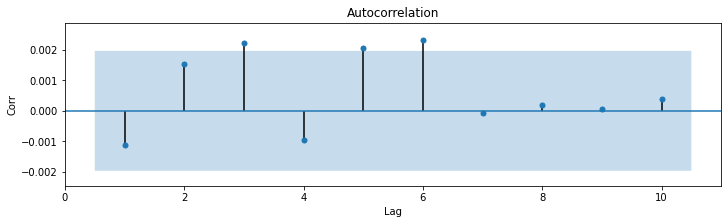

,Ljung-Box Test p-val
lag,
1,0.261626
2,0.165097
3,0.036849
4,0.051549
5,0.018499
6,0.004366
7,0.008541
8,0.015259
9,0.025785


INFO:TRNG Analysis:Doing experiment data_v1/220928_CVa1


data_v1/220928_CVa1


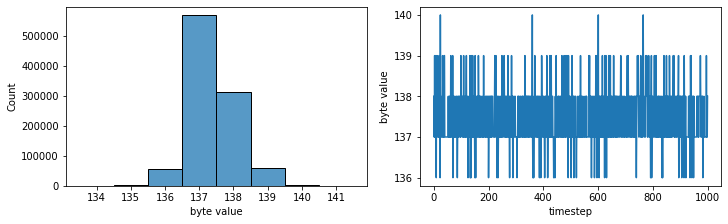

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


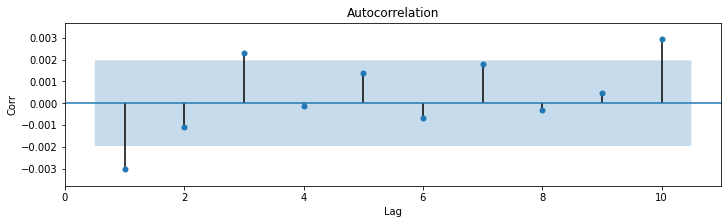

,Ljung-Box Test p-val
lag,
1,0.002499
2,0.005788
3,0.001353
4,0.003530
5,0.003546
6,0.006223
7,0.003487
8,0.006415
9,0.010561


INFO:TRNG Analysis:Doing experiment data_v1/220928_CVa1


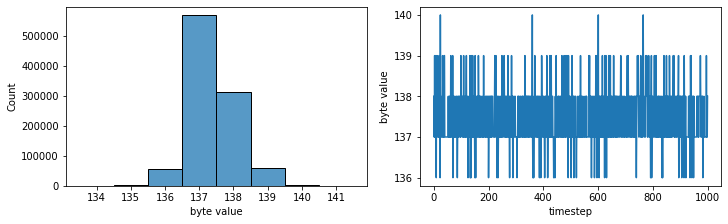

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


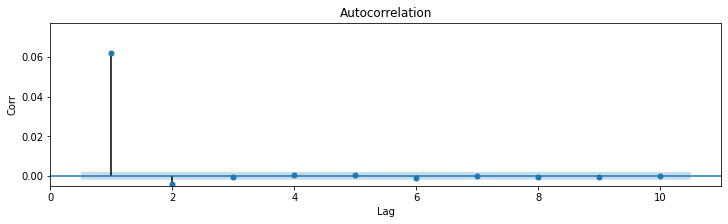

,Ljung-Box Test p-val
lag,
1,0.0
2,0.0
3,0.0
4,0.0
5,0.0
6,0.0
7,0.0
8,0.0
9,0.0


INFO:TRNG Analysis:Doing experiment data_v1/220927_CVa2


data_v1/220927_CVa2


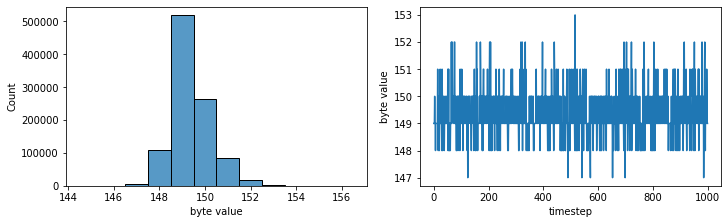

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


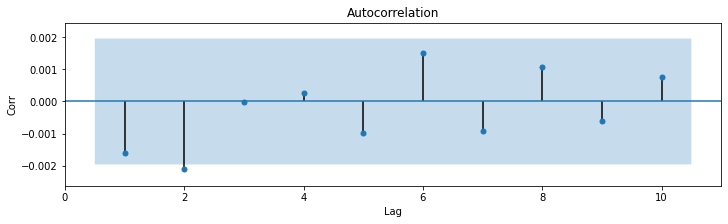

,Ljung-Box Test p-val
lag,
1,0.107761
2,0.030255
3,0.072006
4,0.132591
5,0.153999
6,0.113107
7,0.132529
8,0.138746
9,0.178821


INFO:TRNG Analysis:Doing experiment data_v1/220927_CVa2


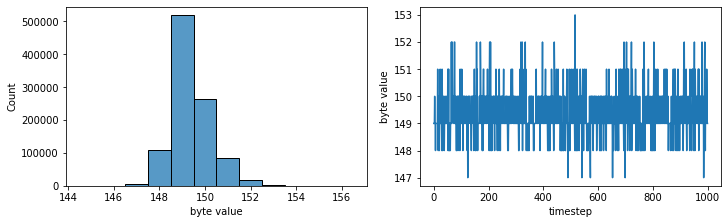

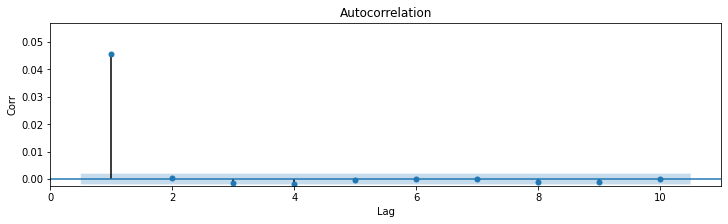

,Ljung-Box Test p-val
lag,
1,0.0
2,0.0
3,0.0
4,0.0
5,0.0
6,0.0
7,0.0
8,0.0
9,0.0


INFO:TRNG Analysis:Doing experiment data_v1/220928_CVa4


data_v1/220928_CVa4


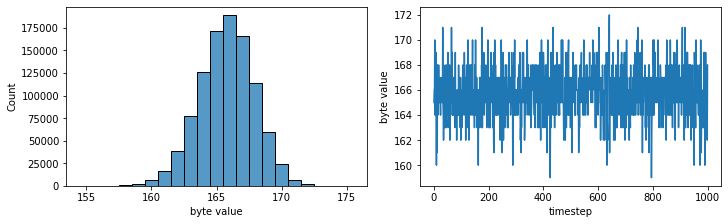

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


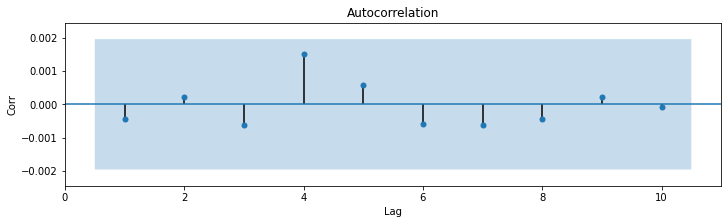

,Ljung-Box Test p-val
lag,
1,0.651972
2,0.880119
3,0.888116
4,0.570924
5,0.662124
6,0.731094
7,0.782401
8,0.842047
9,0.896610


INFO:TRNG Analysis:Doing experiment data_v1/220928_CVa4


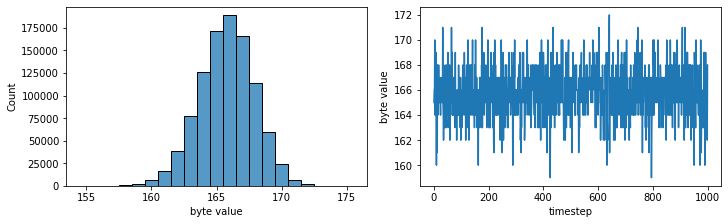

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


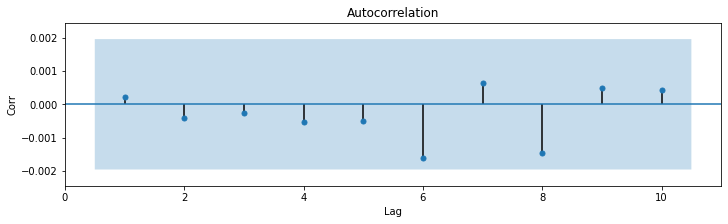

,Ljung-Box Test p-val
lag,
1,0.819804
2,0.899039
3,0.963255
4,0.968437
5,0.977513
6,0.757892
7,0.802597
8,0.650641
9,0.719769


INFO:TRNG Analysis:Doing experiment data_v2/PR_Card_7/220928_CVa2


data_v2/PR_Card_7/220928_CVa2


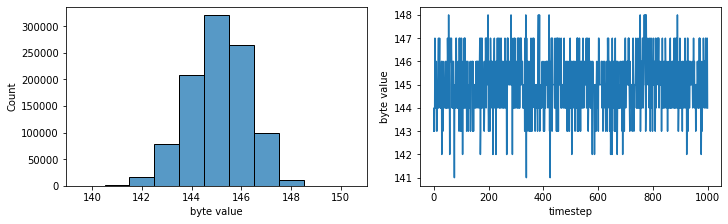

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


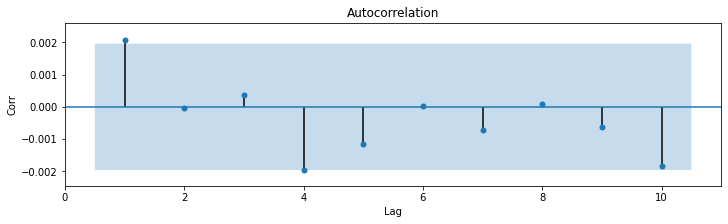

,Ljung-Box Test p-val
lag,
1,0.037013
2,0.113492
3,0.213436
4,0.081856
5,0.087895
6,0.143227
7,0.182250
8,0.256584
9,0.310860


INFO:TRNG Analysis:Doing experiment data_v2/PR_Card_7/220928_CVa2


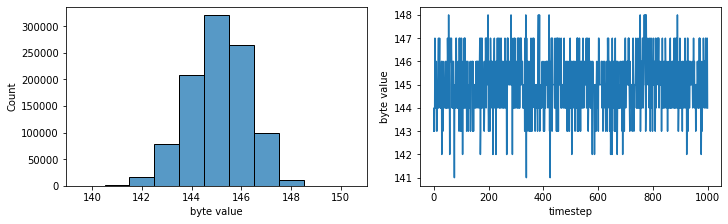

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


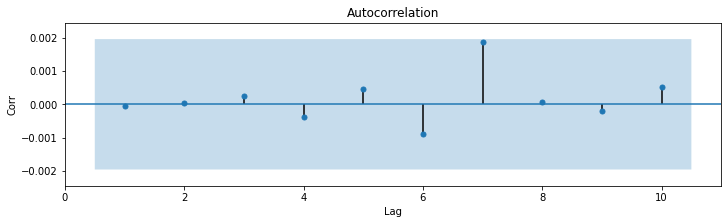

,Ljung-Box Test p-val
lag,
1,0.961426
2,0.997746
3,0.995976
4,0.994689
5,0.994618
6,0.976628
7,0.689116
8,0.782089
9,0.850166


INFO:TRNG Analysis:Doing experiment data_v2/PR_Card_7/220928_CVa1


data_v2/PR_Card_7/220928_CVa1


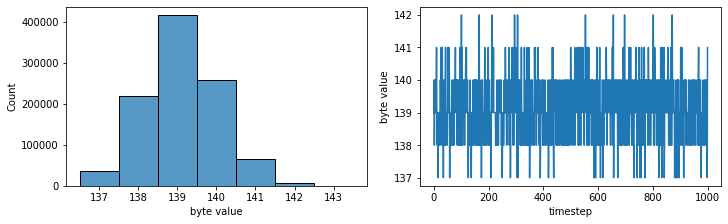

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


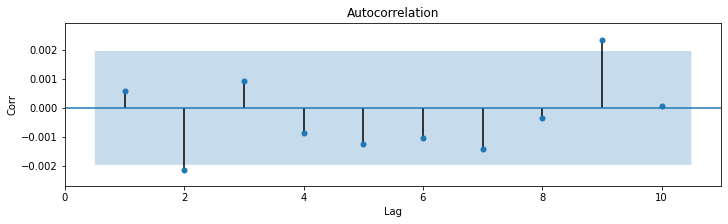

,Ljung-Box Test p-val
lag,
1,0.569122
2,0.085237
3,0.122135
4,0.163041
5,0.153885
6,0.166961
7,0.133388
8,0.188936
9,0.053068


INFO:TRNG Analysis:Doing experiment data_v2/PR_Card_7/220928_CVa1


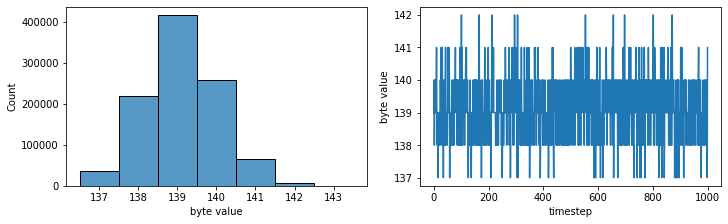

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


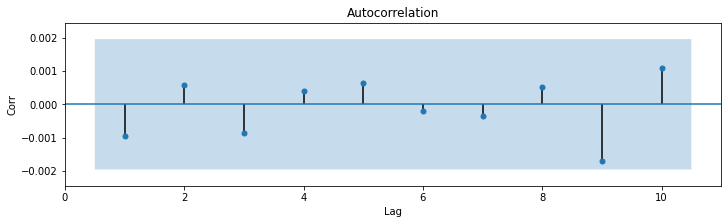

,Ljung-Box Test p-val
lag,
1,0.335511
2,0.529093
3,0.563645
4,0.696808
5,0.759427
6,0.850708
7,0.904950
8,0.931033
9,0.746663


INFO:TRNG Analysis:Doing experiment data_v2/PR_Card_7/220928_CVa4


data_v2/PR_Card_7/220928_CVa4


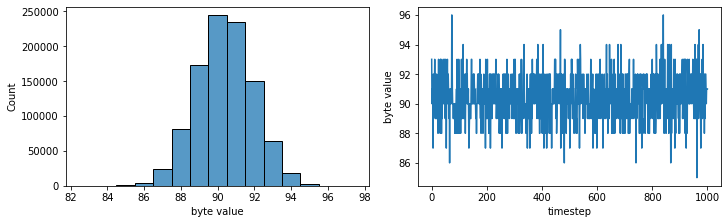

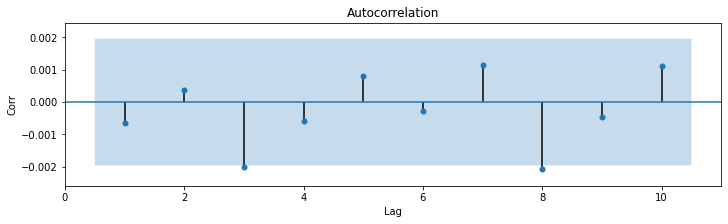

,Ljung-Box Test p-val
lag,
1,0.508444
2,0.748280
3,0.198671
4,0.286215
5,0.341252
6,0.452891
7,0.423605
8,0.182895
9,0.239389


INFO:TRNG Analysis:Doing experiment data_v2/PR_Card_7/220928_CVa4


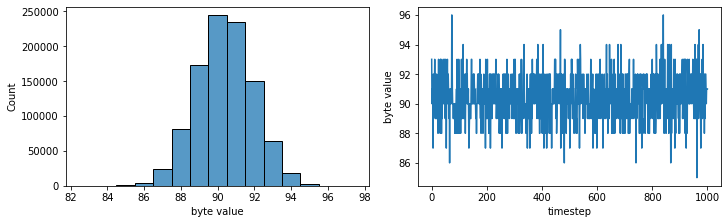

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


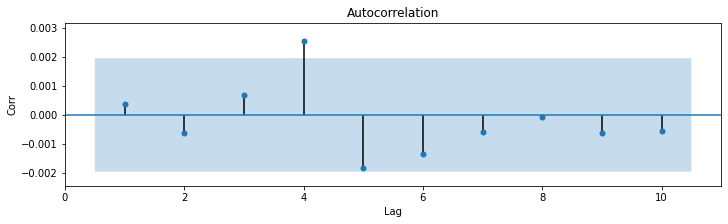

,Ljung-Box Test p-val
lag,
1,0.705753
2,0.768643
3,0.798140
4,0.112250
5,0.055454
6,0.050018
7,0.073895
8,0.114088
9,0.147686


INFO:TRNG Analysis:Doing experiment data_v2/PR_Card_2/220928_CVa2


data_v2/PR_Card_2/220928_CVa2


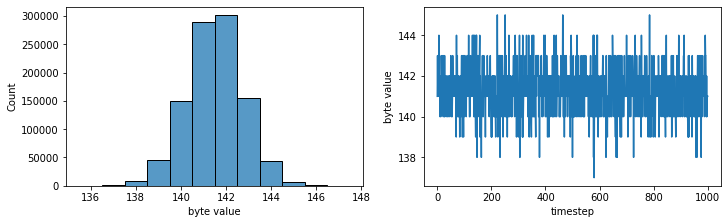

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


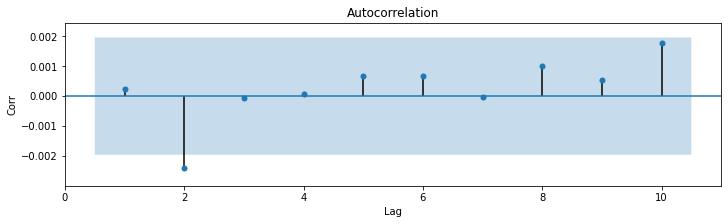

,Ljung-Box Test p-val
lag,
1,0.801097
2,0.054490
3,0.120517
4,0.212443
5,0.278084
6,0.345322
7,0.455987
8,0.456223
9,0.527052


INFO:TRNG Analysis:Doing experiment data_v2/PR_Card_2/220928_CVa2


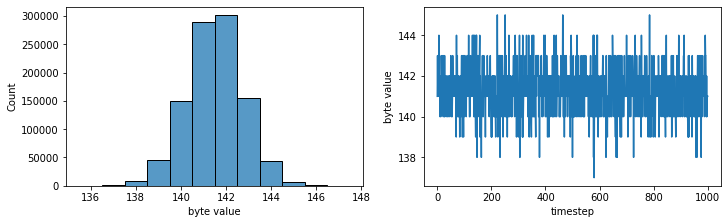

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


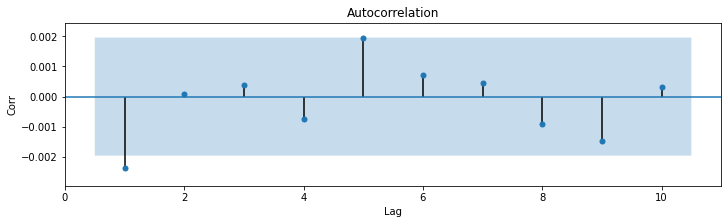

,Ljung-Box Test p-val
lag,
1,0.017880
2,0.060265
3,0.123762
4,0.178444
5,0.074141
6,0.102500
7,0.148630
8,0.168698
9,0.130328


INFO:TRNG Analysis:Doing experiment data_v2/PR_Card_2/220928_CVa1


data_v2/PR_Card_2/220928_CVa1


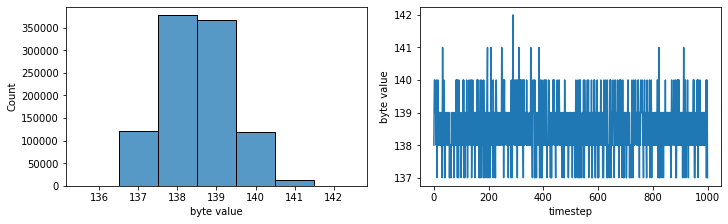

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


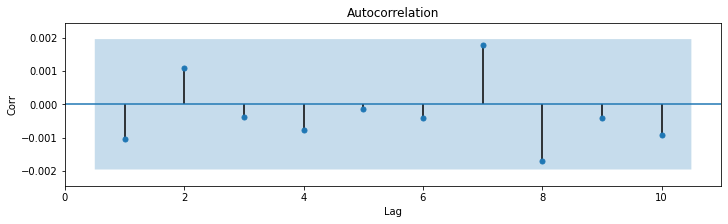

,Ljung-Box Test p-val
lag,
1,0.303671
2,0.326535
3,0.495895
4,0.558553
5,0.697160
6,0.784085
7,0.497482
8,0.322740
9,0.400462


INFO:TRNG Analysis:Doing experiment data_v2/PR_Card_2/220928_CVa1


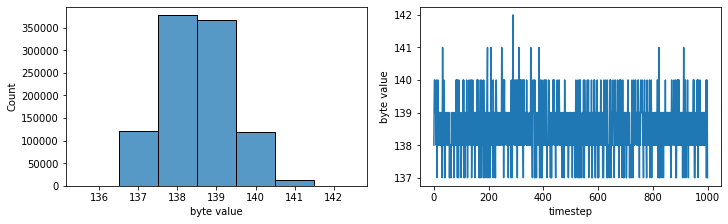

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


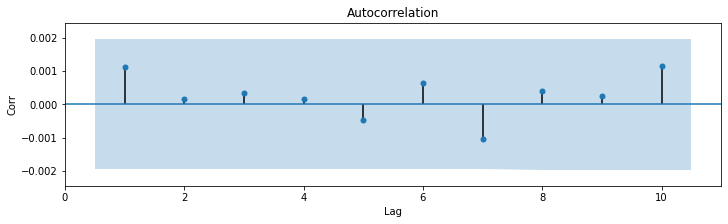

,Ljung-Box Test p-val
lag,
1,0.266569
2,0.531736
3,0.712855
4,0.845272
5,0.900483
6,0.919633
7,0.876288
8,0.918172
9,0.950757


INFO:TRNG Analysis:Doing experiment data_v2/PR_Card_2/220928_CVa4


data_v2/PR_Card_2/220928_CVa4


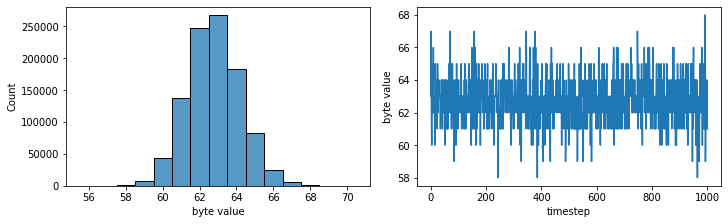

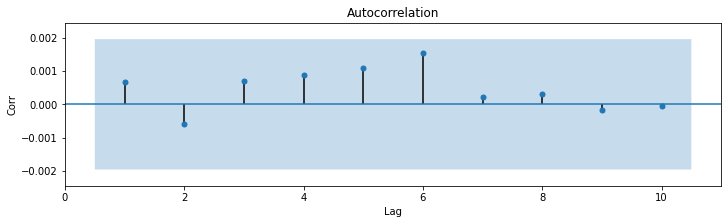

,Ljung-Box Test p-val
lag,
1,0.506165
2,0.677531
3,0.737661
4,0.733218
5,0.665921
6,0.469634
7,0.581593
8,0.675647
9,0.761893


INFO:TRNG Analysis:Doing experiment data_v2/PR_Card_2/220928_CVa4


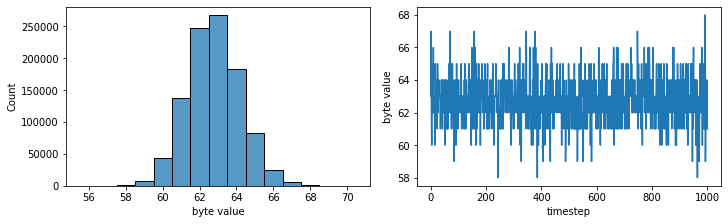

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


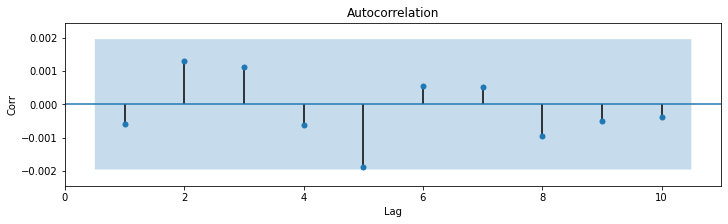

,Ljung-Box Test p-val
lag,
1,0.561615
2,0.366477
3,0.348040
4,0.449094
5,0.199956
6,0.269281
7,0.344254
8,0.361330
9,0.433869


INFO:TRNG Analysis:Doing experiment data_v3/220929_SFa4_DBv11-12


data_v3/220929_SFa4_DBv11-12


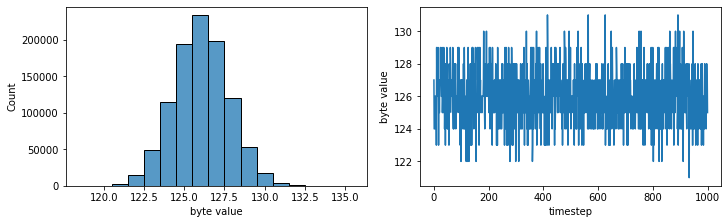

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


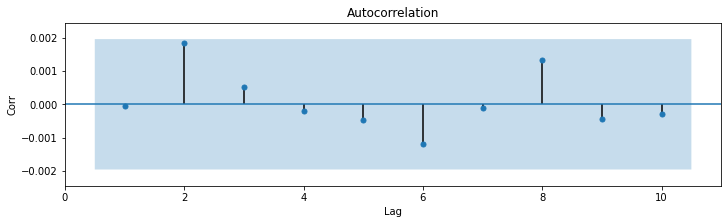

,Ljung-Box Test p-val
lag,
1,0.967270
2,0.178500
3,0.295086
4,0.440724
5,0.555179
6,0.498286
7,0.614324
8,0.516652
9,0.597516


INFO:TRNG Analysis:Doing experiment data_v3/220929_SFa4_DBv11-12


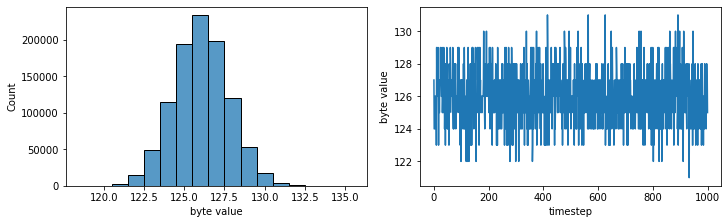

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


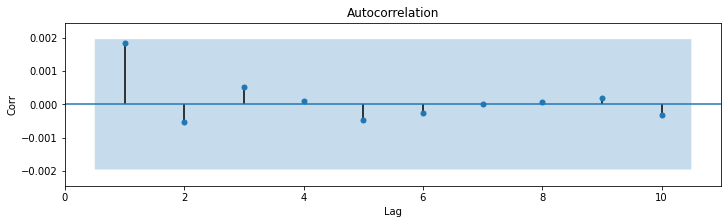

,Ljung-Box Test p-val
lag,
1,0.063453
2,0.154986
3,0.261770
4,0.405009
5,0.516248
6,0.636559
7,0.744992
8,0.828914
9,0.888015


INFO:TRNG Analysis:Doing experiment data_v3/220929_SFa1_DBv11-12


data_v3/220929_SFa1_DBv11-12


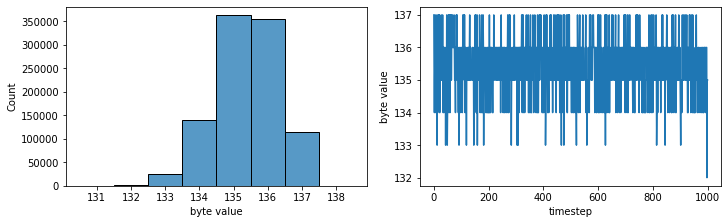

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


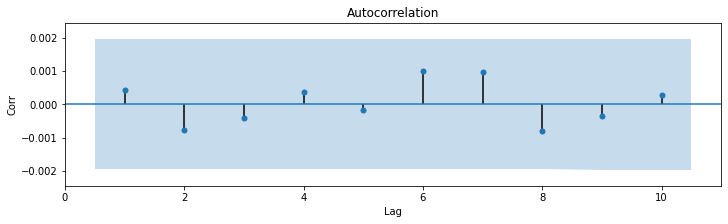

,Ljung-Box Test p-val
lag,
1,0.664287
2,0.676098
3,0.815076
4,0.898730
5,0.953800
6,0.909744
7,0.881397
8,0.883951
9,0.923311


INFO:TRNG Analysis:Doing experiment data_v3/220929_SFa1_DBv11-12


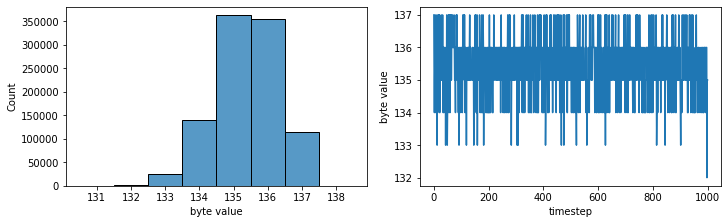

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


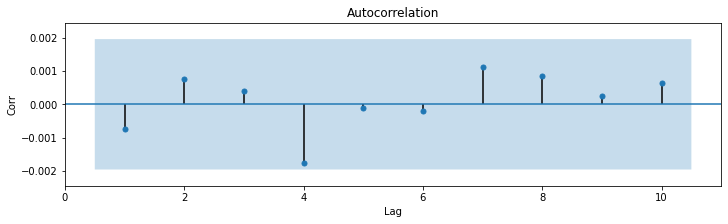

,Ljung-Box Test p-val
lag,
1,0.455539
2,0.561569
3,0.728083
4,0.348667
5,0.484886
6,0.609535
7,0.568929
8,0.593655
9,0.684669


INFO:TRNG Analysis:Doing experiment data_v3/220929_SFa2_DBv11-12


data_v3/220929_SFa2_DBv11-12


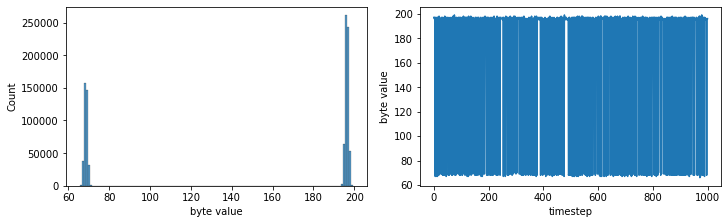

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


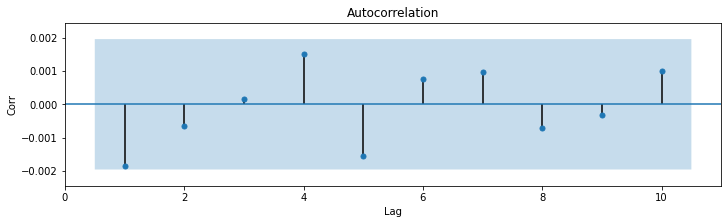

,Ljung-Box Test p-val
lag,
1,0.064305
2,0.147090
3,0.277085
4,0.186956
5,0.128608
6,0.167305
7,0.184180
8,0.225171
9,0.296932


INFO:TRNG Analysis:Doing experiment data_v3/220929_SFa2_DBv11-12


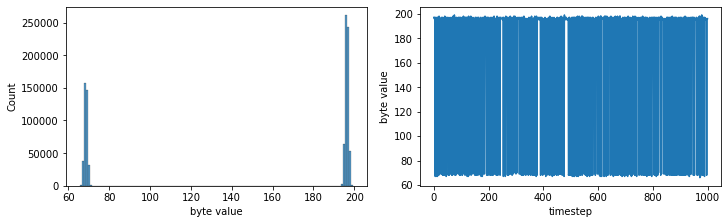

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


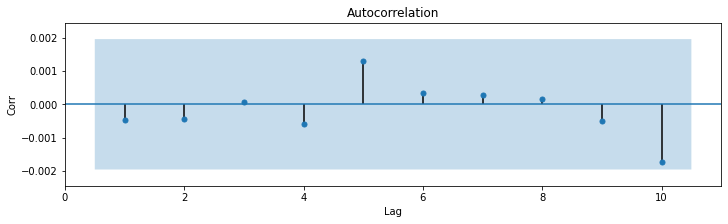

,Ljung-Box Test p-val
lag,
1,0.627776
2,0.802086
3,0.930672
4,0.938680
5,0.774666
6,0.852767
7,0.909924
8,0.949335
9,0.964464


In [ ]:
for path in Path('').rglob(r'*cnt.bin'):
  exp_name = path.parent
  print(exp_name)
  for fn in [last_bit,diff_last_bit]:
    with mlflow.start_run(run_name=exp_name):
      logger.info(f'Doing experiment {exp_name}')
      bytes_data = get_bytes_data(path)
      analyze_series(bytes_data,postprocess_fn=fn)

# Notes

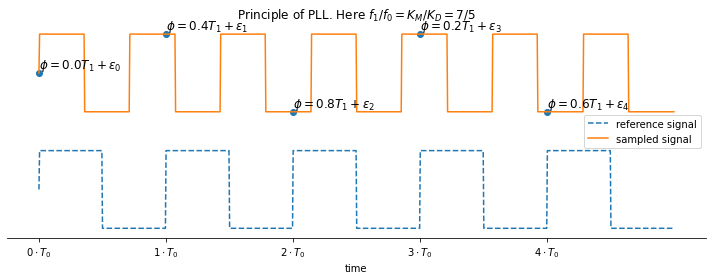

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = [10,4]

fig, ax = plt.subplots()
f0 = 5
ts = np.linspace(0,1,1000)
y0= np.sign( np.sin(2*np.pi*f0*ts) )
y0 = -3+y0
ax.plot(ts,y0,linestyle='dashed',label='reference signal')

f1 = 7
y1 = np.sign( np.sin(2*np.pi*f1*ts) )
ax.plot(ts,y1,label='sampled signal')

ts_sampled = np.arange(int(f0))*1/f0
y1_sampled = np.sign( np.sin(2*np.pi*f1*ts_sampled) )
ax.scatter(ts_sampled, y1_sampled)

annotations = ['ble' for _ in ts_sampled]
for i,(text,t,y) in enumerate(zip(annotations,ts_sampled,y1_sampled)):
  phi = np.remainder(t,1/f1)*f1
  phi = phi.round(3)
  ax.text(t,y,f'$\phi={phi} T_1 + \epsilon_{i} $',ha="left", va="bottom",size=12)


ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_yticks([])
ax.set_xticks(ts_sampled)
ax.set_xticklabels([f'${t:.0f}\cdot T_0$' for t in ts_sampled*f0])

ax.legend()
ax.set_title('Principle of PLL. Here $f_1/f_0 = K_M/K_D = 7/5$')# = \frac{7}{5} = \frac{K_M}{K_D}$')
ax.set_xlabel('time')

plt.tight_layout()

The phases of the sampled signal are
$\phi_i = i\cdot \Delta + \epsilon_i \mod T_1 $ where $\Delta = T_1/K_D$ and $\epsilon_i\sim \mathrm{Norm}(0,\sigma^2)$ is the jitter.

We define the counter
$$
N = \sum_{i=1}^{K_D} \mathbb{1}(\phi_i \in (0,T_1/2) )
$$



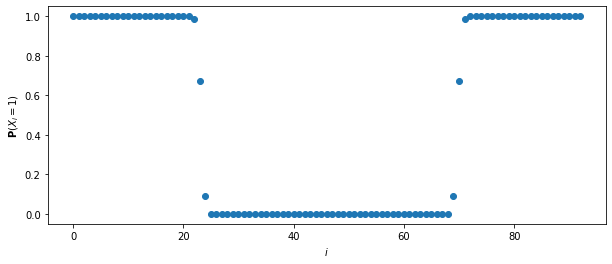

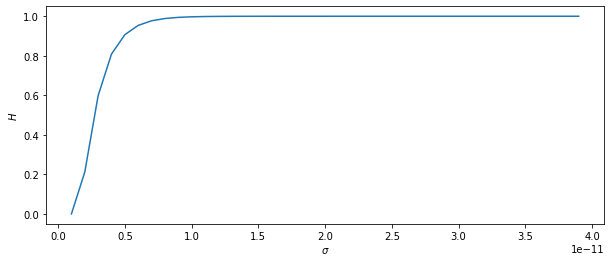

0.5059378032788413 0.9998982659454103


In [ ]:
import numpy as np
from scipy.stats import norm
from scipy.stats import entropy
import matplotlib.pyplot as plt
from scipy.special import erf

def get_bit_probs_v1(T1,K_D,sigma,phi0_frac):
  """Comuptes probabilities of reordered samples, 
    cf. Eq (4) in "Modern random number generator design – Case study on a secured PLL-based TRNG"""
  i = np.arange(0,K_D) # ordered index from 0 to K_D-1
  Delta = T1/K_D
  phi0 = phi0_frac*T1 # initial_phase
  phi_i = np.remainder(phi0+i*Delta,T1) # signal phases at subsequent samples
  jitter_dist = norm(loc=phi_i,scale=sigma)
  part1 = jitter_dist.cdf(T1/2)-jitter_dist.cdf(0)
  part2 = jitter_dist.cdf(3*T1/2)-jitter_dist.cdf(T1)
  p = part1+part2
  return i,p

def get_bit_probs_v2(T1,K_D,sigma,phi0_frac):
  """Comuptes probabilities of reordered samples, 
    cf. Eq (4) in "Modern random number generator design – Case study on a secured PLL-based TRNG"""
  i = np.arange(0,K_D) # ordered index from 0 to K_D-1
  denom = np.sqrt(2)*sigma/T1
  p = 1- 0.5*erf((i/K_D-phi0_frac)/denom) + 0.5*erf((i/K_D-0.5-phi0_frac)/denom)
  return i,p

get_bit_probs = get_bit_probs_v2

## Test 1: reproduce Fig 7. from "Modern random number generator design – Case study on a secured PLL-based TRNG"

i,ps = get_bit_probs(
  sigma = 9.6*1e-12,
  T1 = 1/( 634.7*1e6 ),
  K_D = 93,
  phi0_frac = 0.25,
)
plt.scatter(i,ps)
plt.xlabel('$i$')
plt.ylabel('$\mathbf{P}(X_i=1)$')
plt.show()

## Test 2: reproduce Fig. 8 (plot 1) from "Modern random number generator design – Case study on a secured PLL-based TRNG"

sigmas = np.arange(1,40)*1e-12
entropy_rates = []
for sigma in sigmas:
  _,ps = get_bit_probs(
    sigma = sigma,
    T1 = 1/( 634.7*1e6 ),
    K_D = 93,
    phi0_frac = 0.25,
  )
  total_p = 1/2+1/2*np.prod(2*ps-1) # as per the formula of Davies
  entropy_rate = entropy([total_p,1-total_p],base=2)
  entropy_rates.append(entropy_rate)

plt.plot(sigmas,entropy_rates)
plt.xlabel('$\sigma$')
plt.ylabel('$H$')
plt.show()

## Test 3: reproduce Tab. 4 (config 1) from "Modern random number generator design – Case study on a secured PLL-based TRNG"

_,ps = get_bit_probs(
  sigma =8.72*1e-12,
  T1 = 1/( 360.1*1e6 ),
  K_D = 279,
  phi0_frac = 0.25, # not sure if we shift the phase?
)

total_p = 1/2+1/2*np.prod(2*ps-1) # as per the formula of Davies
print(total_p,entropy([total_p,1-total_p],base=2))

Artificial reduction!
Reverse the roles of wave and its reference!


* We sample with the reference signal, at frequency $f_0$
* So, rising eges at the sampled signal occur at phases $\phi_i = 
i\cdot T_0 \mod T_1  $
* After rearanging the order, we have $\phi_j = i / K_D \cdot T_1$ where $f_1/f_0 = K_M/K_D$
* In the jitter setup, we assume $\phi_j \sim  i / K_D + \epsilon_j \mod T_1$ where $\epsilon_j \sim N(0,\sigma^2)$
* The bit is one when $\phi_i \in [0,T_1/2]$ and zero otherwise


The equivalent model: the rising edges appear at times $t_i = i\cdot T_0 + \epsilon_i$, we emit $b_i=1$ when
$t_i \mod T_1 < T_1/2$ and $b_i=0$ otherwise.

Then we can apply Schindler's Paper!

We have $\Delta t_i  \sim \epsilon_i - \epsilon_{i-1}$ is 2-independent.


How to estimate entropy
$$
\mathbf{H}(Y_n | Y_{1},\ldots,Y_{n}) \geqslant \mathbf{H}(Y_n | R_{n-1})
$$

so 
$$
\sum_i \mathbf{1}_{0,T/2}(t_i \mod T)
$$







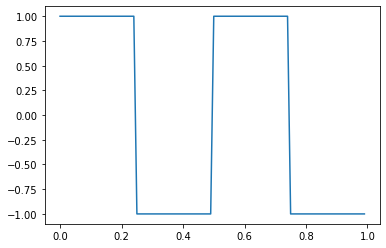

In [ ]:
#from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
ts = np.linspace(0, 1, 100, endpoint=False)
wave = signal.square(2*np.pi*ts*2)
plt.plot(ts, wave)

## Correlations

In [ ]:
def dff_plot(filename, KM, KD):
    raw_data = np.fromfile(filename, dtype="uint8")
    
    # read data choosing the order
    bin_data = np.unpackbits(raw_data, axis=None, count=None, bitorder='little')
    bin_data[0:32]=bin_data[31::-1]
    for i in range(len(bin_data)//32):
        if i>0:
            bin_data[(i*32):((i+1)*32)]=bin_data[((i+1)*32)-1:(i*32)-1:-1]
    #np.savetxt("bin_data.csv", bin_data, delimiter="\t")
    
    # cut Tq periods according to KD
    if len(bin_data)%KD>0:
        bin_data=np.resize(bin_data,(len(bin_data)//KD)*KD) ;# cut last Tq if not full
    img = np.reshape(bin_data,((len(bin_data)//KD),KD)) # (N_CYCLES, KD)
    #np.savetxt("img.csv", img, delimiter="\t")
    
    # reorder Tq period
    j=[(i*KM)%KD for i in range(KD)] ;# reordered period
    somme=np.sum(img,0)    ;# sum by position
    nsum=somme / len(img)  ;# normalized sum
    z=zip(j,nsum)          ;# zip position and values
    uz=list(zip(*sorted(z)))    ;# sort and unzip
    periode=uz[1]

    # plot Tq period
    x=range(0, KD)
    y=periode
    plt.plot(x,y,'+', markersize=4)
    plt.xlabel('$K_D$', fontsize = 12, family = 'serif')
    plt.ylabel('P(X=1)', fontsize = 12, family = 'serif')
    plt.savefig(filename[:-4] + '.pdf')
    plt.show()



def read_dff(filename, KM, KD):
    raw_data = np.fromfile(filename, dtype="uint8")
    
    # read data choosing the order
    bin_data = np.unpackbits(raw_data, axis=None, count=None, bitorder='little')
    bin_data[0:32]=bin_data[31::-1]
    for i in range(len(bin_data)//32):
        if i>0:
            bin_data[(i*32):((i+1)*32)]=bin_data[((i+1)*32)-1:(i*32)-1:-1]
    #np.savetxt("bin_data.csv", bin_data, delimiter="\t")
    
    # cut Tq periods according to KD
    if len(bin_data)%KD>0:
        bin_data=np.resize(bin_data,(len(bin_data)//KD)*KD) ;# cut last Tq if not full
    img = np.reshape(bin_data,((len(bin_data)//KD),KD)) # (N_CYCLES, KD)
    return img


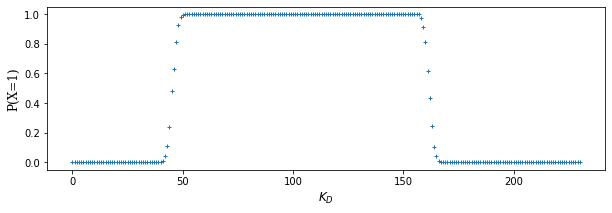

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

filename = '/content/data_CV_c_and_CV_d_dff/CVd1/acq_20221005094040_dff.bin'
KM = 470
KD = 231
dff_plot(filename=filename,KM=KM,KD=KD)

Index i of random bits in time domain:
[113 118 123 128 230 235 240 245]
Correponding position j(i) of random bits:
[ 77  76  75  74 203 202 201 200]
Ordered position j(i) of random bits:
[ 74  75  76  77 200 201 202 203]


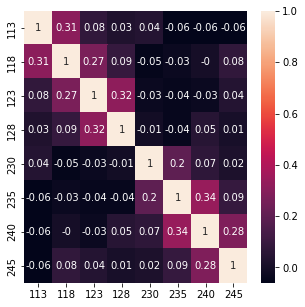

[[ 1.    0.31  0.08  0.03  0.04 -0.06 -0.06 -0.06]
 [ 0.31  1.    0.27  0.09 -0.05 -0.03 -0.    0.08]
 [ 0.08  0.27  1.    0.32 -0.03 -0.04 -0.03  0.04]
 [ 0.03  0.09  0.32  1.   -0.01 -0.04  0.05  0.01]
 [ 0.04 -0.05 -0.03 -0.01  1.    0.2   0.07  0.02]
 [-0.06 -0.03 -0.04 -0.04  0.2   1.    0.34  0.09]
 [-0.06 -0.   -0.03  0.05  0.07  0.34  1.    0.28]
 [-0.06  0.08  0.04  0.01  0.02  0.09  0.28  1.  ]]
Most correlated bits are [235 240]  with correlation 0.34
Index i of random bits in time domain:
[  6  20  34  35  49  63  64  78  92  93 107 121 136 150 165 179 193 194
 208 222]
Correponding position j(i) of random bits:
[ 48 160  41  49 161  42  50 162  43  51 163  44 164  45 165  46 158 166
  47 159]
Ordered position j(i) of random bits:
[ 41  42  43  44  45  46  47  48  49  50  51 158 159 160 161 162 163 164
 165 166]


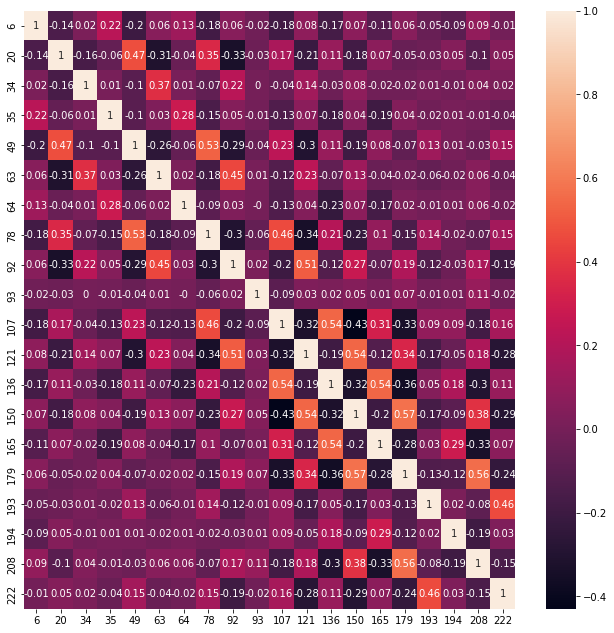

[[ 1.   -0.14  0.02  0.22 -0.2   0.06  0.13 -0.18  0.06 -0.02 -0.18  0.08
  -0.17  0.07 -0.11  0.06 -0.05 -0.09  0.09 -0.01]
 [-0.14  1.   -0.16 -0.06  0.47 -0.31 -0.04  0.35 -0.33 -0.03  0.17 -0.21
   0.11 -0.18  0.07 -0.05 -0.03  0.05 -0.1   0.05]
 [ 0.02 -0.16  1.    0.01 -0.1   0.37  0.01 -0.07  0.22  0.   -0.04  0.14
  -0.03  0.08 -0.02 -0.02  0.01 -0.01  0.04  0.02]
 [ 0.22 -0.06  0.01  1.   -0.1   0.03  0.28 -0.15  0.05 -0.01 -0.13  0.07
  -0.18  0.04 -0.19  0.04 -0.02  0.01 -0.01 -0.04]
 [-0.2   0.47 -0.1  -0.1   1.   -0.26 -0.06  0.53 -0.29 -0.04  0.23 -0.3
   0.11 -0.19  0.08 -0.07  0.13  0.01 -0.03  0.15]
 [ 0.06 -0.31  0.37  0.03 -0.26  1.    0.02 -0.18  0.45  0.01 -0.12  0.23
  -0.07  0.13 -0.04 -0.02 -0.06 -0.02  0.06 -0.04]
 [ 0.13 -0.04  0.01  0.28 -0.06  0.02  1.   -0.09  0.03 -0.   -0.13  0.04
  -0.23  0.07 -0.17  0.02 -0.01  0.01  0.06 -0.02]
 [-0.18  0.35 -0.07 -0.15  0.53 -0.18 -0.09  1.   -0.3  -0.06  0.46 -0.34
   0.21 -0.23  0.1  -0.15  0.14 -0.02 -0.07  0.15]
 

(13, 15)

In [ ]:
def test_correlation(filename,KM,KD):
  img = read_dff(filename=filename,KD=KD,KM=KM)

  probs = img.mean(0) # (KD,)
  mask = (probs > prob_ts) & (probs < 1-prob_ts) # exclude deterministic samples
  non_trivial_bits = img[:,mask]

  non_trivial_is = np.arange(KD)[mask]
  non_trivial_js =  non_trivial_is * KM % KD
  print('Index i of random bits in time domain:')
  print(non_trivial_is)
  print('Correponding position j(i) of random bits:')
  print(non_trivial_js)
  non_trivial_js.sort()
  print('Ordered position j(i) of random bits:')
  print(non_trivial_js)

  # Adapting the figsize to the dimension of the heatmap
  plt.rcParams['figure.figsize'] = [1+sum(mask)/2,1+sum(mask)/2]

  pearson_corr = np.corrcoef(non_trivial_bits.T).round(2)
  sns.heatmap(
      data=pearson_corr,
      annot=True,
      xticklabels=non_trivial_is,
      yticklabels=non_trivial_is)
  plt.show()
  print(pearson_corr)
  return pearson_corr, non_trivial_is


def find_worst_correlation(corrs, bit_pos):
  # Artificially ignore the diagonal coefficients
  for i in range(len(corrs)):
    corrs[i,i]=0
  
  worst_corr_pos = np.unravel_index(np.argmax(np.abs(corrs), axis=None), corrs.shape)
  worst_corr_bits = bit_pos.take(worst_corr_pos)
  print(f'Most correlated bits are {worst_corr_bits}',
        f' with correlation {corrs[worst_corr_pos]}')
  return worst_corr_pos


# Treshold to exclude "not random enough" bits of interest
# Should be between 0 (exclude none) and 1/2 (exclude all)
prob_ts = 0

filename = '/content/data_CV_c_and_CV_d_dff/CVc1/acq_20221005092918_dff.bin'
KM=448
KD=249
corr_matrix, i_values = test_correlation(filename,KM,KD)
find_worst_correlation(corr_matrix, i_values)

filename = '/content/data_CV_c_and_CV_d_dff/CVd1/acq_20221005094040_dff.bin'
KM = 470
KD = 231
corr_matrix, i_values = test_correlation(filename,KM,KD)
find_worst_correlation(corr_matrix, i_values)

In [ ]:
print(corr_matrix)

[[ 0.   -0.14  0.02  0.22 -0.2   0.06  0.13 -0.18  0.06 -0.02 -0.18  0.08
  -0.17  0.07 -0.11  0.06 -0.05 -0.09  0.09 -0.01]
 [-0.14  0.   -0.16 -0.06  0.47 -0.31 -0.04  0.35 -0.33 -0.03  0.17 -0.21
   0.11 -0.18  0.07 -0.05 -0.03  0.05 -0.1   0.05]
 [ 0.02 -0.16  0.    0.01 -0.1   0.37  0.01 -0.07  0.22  0.   -0.04  0.14
  -0.03  0.08 -0.02 -0.02  0.01 -0.01  0.04  0.02]
 [ 0.22 -0.06  0.01  0.   -0.1   0.03  0.28 -0.15  0.05 -0.01 -0.13  0.07
  -0.18  0.04 -0.19  0.04 -0.02  0.01 -0.01 -0.04]
 [-0.2   0.47 -0.1  -0.1   0.   -0.26 -0.06  0.53 -0.29 -0.04  0.23 -0.3
   0.11 -0.19  0.08 -0.07  0.13  0.01 -0.03  0.15]
 [ 0.06 -0.31  0.37  0.03 -0.26  0.    0.02 -0.18  0.45  0.01 -0.12  0.23
  -0.07  0.13 -0.04 -0.02 -0.06 -0.02  0.06 -0.04]
 [ 0.13 -0.04  0.01  0.28 -0.06  0.02  0.   -0.09  0.03 -0.   -0.13  0.04
  -0.23  0.07 -0.17  0.02 -0.01  0.01  0.06 -0.02]
 [-0.18  0.35 -0.07 -0.15  0.53 -0.18 -0.09  0.   -0.3  -0.06  0.46 -0.34
   0.21 -0.23  0.1  -0.15  0.14 -0.02 -0.07  0.15]
 

### Stationarity/Correlation Experiment

In [ ]:
filename = '/content/data_CV_c_and_CV_d_dff/CVd1/acq_20221005094040_dff.bin'
KM = 470
KD = 231

img = read_dff(filename=filename,KD=KD,KM=KM)
img.shape

(346, 231)

In [ ]:
position_j = 0
bytes_series = img[:,position_j]
results = kpss(bytes_series,nlags=10)
results[1]


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

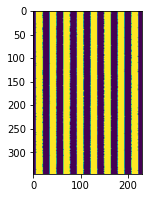

In [ ]:
plt.imshow(img)

For rows $i$ (subsequent $T_Q$ periods), we consider samples $j=0..K_D-1$
$$
X_{i,j}
$$

Then
- Stationarity for $X_{i,\bullet}$ for every $j$-fixed.
- Independentce of $X_{\bullet,j}$ (also used when XORing, Dav02)

give us stationarity of the group of bits $X_{i,\bullet}$



